In [ ]:
import numpy as np
import xarray as xr
import warnings
from pathlib import Path
from pandas import date_range

import pycompo.core.composite as pccompo
import pycompo.core.utils as pcutil
from pycompo.core.sst_features import set_global_feature_id

warnings.filterwarnings(action='ignore')

# read in configuration file
config_file = "/home/m/m300738/libs/pycompo/config/settings_ngc5004_pc03.yaml"
config = pcutil.read_yaml_config(config_file)

start_time = config['data']['analysis_time'][0]
end_time = config['data']['analysis_time'][1]
analysis_times = [
    np.datetime64(t) for t in date_range(
        np.datetime64(start_time), np.datetime64(end_time), freq='MS',
        )
    ]
analysis_times = analysis_times[:4]

feature_var = config['data']['feature_var']
analysis_idf = f"{config['exp']}_{config['pycompo_name']}"

### Preparations for composite subsampling

In [ ]:
quantiles = config['composite']['subgroup_quantiles']

# load feature_props
inpath = Path(f"{config['data']['outpath']}/{analysis_idf}/")
infile = Path(f"{analysis_idf}_feature_props_all.nc")
feature_props = xr.open_dataset(str(inpath/infile))
feature_props_quants = feature_props.quantile([0.25, 0.5, 0.75])

# build rainbelt if necessary
if config['composite']['rainbelt_subsampling']['switch']:
    rainbelt = pccompo.get_rainbelt(analysis_times, config, quantile=0.8)
    infile = Path(f"{analysis_idf}_feature_props_rainbelt_all.nc")
    feature_props_rainbelt = xr.open_dataset(str(inpath/infile))
    feature_props_rainbelt_quants = feature_props_rainbelt.quantile(quantiles)

### Read in feature_data

In [ ]:
# ----------------------------------------------------------------------
# create a single feature composite
# ---------------------------------
keep_props = [
    'radius_km', 'area_km2', 'bg_uas', 'bg_vas', 'bg_sfcwind', 'bg_sfcwind_dir',
    'ts_ano_mean', 'axis_major_length_idx', 'axis_minor_length_idx',
    'orientation_idx',
    ]

inpath = Path(f"{config['data']['outpath']}/{analysis_idf}/features/")
full_compo = []
rainbelt_compo = []

feature_props = []
feature_props_rainbelt = []
for i in range (len(analysis_times)-1):
    # read in data
    file_timestr = \
        f"{pcutil.np_datetime2file_datestr(analysis_times[i])}-" + \
        f"{pcutil.np_datetime2file_datestr(analysis_times[i+1])}"
    infile = inpath/Path(f"{analysis_idf}_features_{file_timestr}.nc")
    features = xr.open_dataset(infile).compute()
    feature_props.append(features[keep_props])

    # Precipitation-based geographic subsampling
    if config['composite']['rainbelt_subsampling']['switch']:
        features_rainbelt = pccompo.sample_features_geomask(features, rainbelt)
        feature_props_rainbelt.append(features_rainbelt[keep_props])

    # Basin-based geographic subsampling
    # TODO: Implement basin-based geographical subsampling

    full_compo.append(features.mean(dim='feature'))
    rainbelt_compo.append(features_rainbelt.mean(dim='feature'))

full_compo = xr.concat(full_compo, dim='month').mean(dim='month')
rainbelt_compo = xr.concat(rainbelt_compo, dim='month').mean(dim='month')

feature_props = xr.concat(set_global_feature_id(feature_props), dim='feature')
feature_props_rainbelt = xr.concat(
    set_global_feature_id(feature_props_rainbelt), dim='feature',
    )

### Visualization of feature statistics

In [72]:
full_compo

<xarray.Dataset>
Dimensions:                (component: 2, x: 51, y: 51)
Coordinates:
  * component              (component) object 'lat' 'lon'
    En_rota2_featcen_x     (x) float64 -2.5 -2.4 -2.3 -2.2 ... 2.2 2.3 2.4 2.5
    En_rota2_featcen_y     (y) float64 -2.5 -2.4 -2.3 -2.2 ... 2.2 2.3 2.4 2.5
Dimensions without coordinates: x, y
Data variables: (12/25)
    radius_km              float64 28.85
    area_km2               float64 4.166e+03
    centroid_idx           (component) float64 152.5 1.682e+03
    axis_major_length_idx  float64 10.18
    axis_minor_length_idx  float64 4.386
    orientation_idx        float64 0.03897
    ...                     ...
    rlut_ano               (x, y) float64 -0.5874 -0.5787 ... -1.048 -1.064
    cllvi_ano              (x, y) float64 0.001318 0.00131 ... 0.003649 0.003637
    clivi_ano              (x, y) float64 0.000257 0.0002464 ... 0.0007064
    sfcwind_ano            (x, y) float64 -0.05366 -0.05352 ... -0.06896
    sfcwind_conv_ano       (x, y) float64 -4.442e-07 -4.307e-07 ... -1.588e-08
    ps_ano                 (x, y) float64 -1.497 -1.497 -1.492 ... -1.708 -1.701

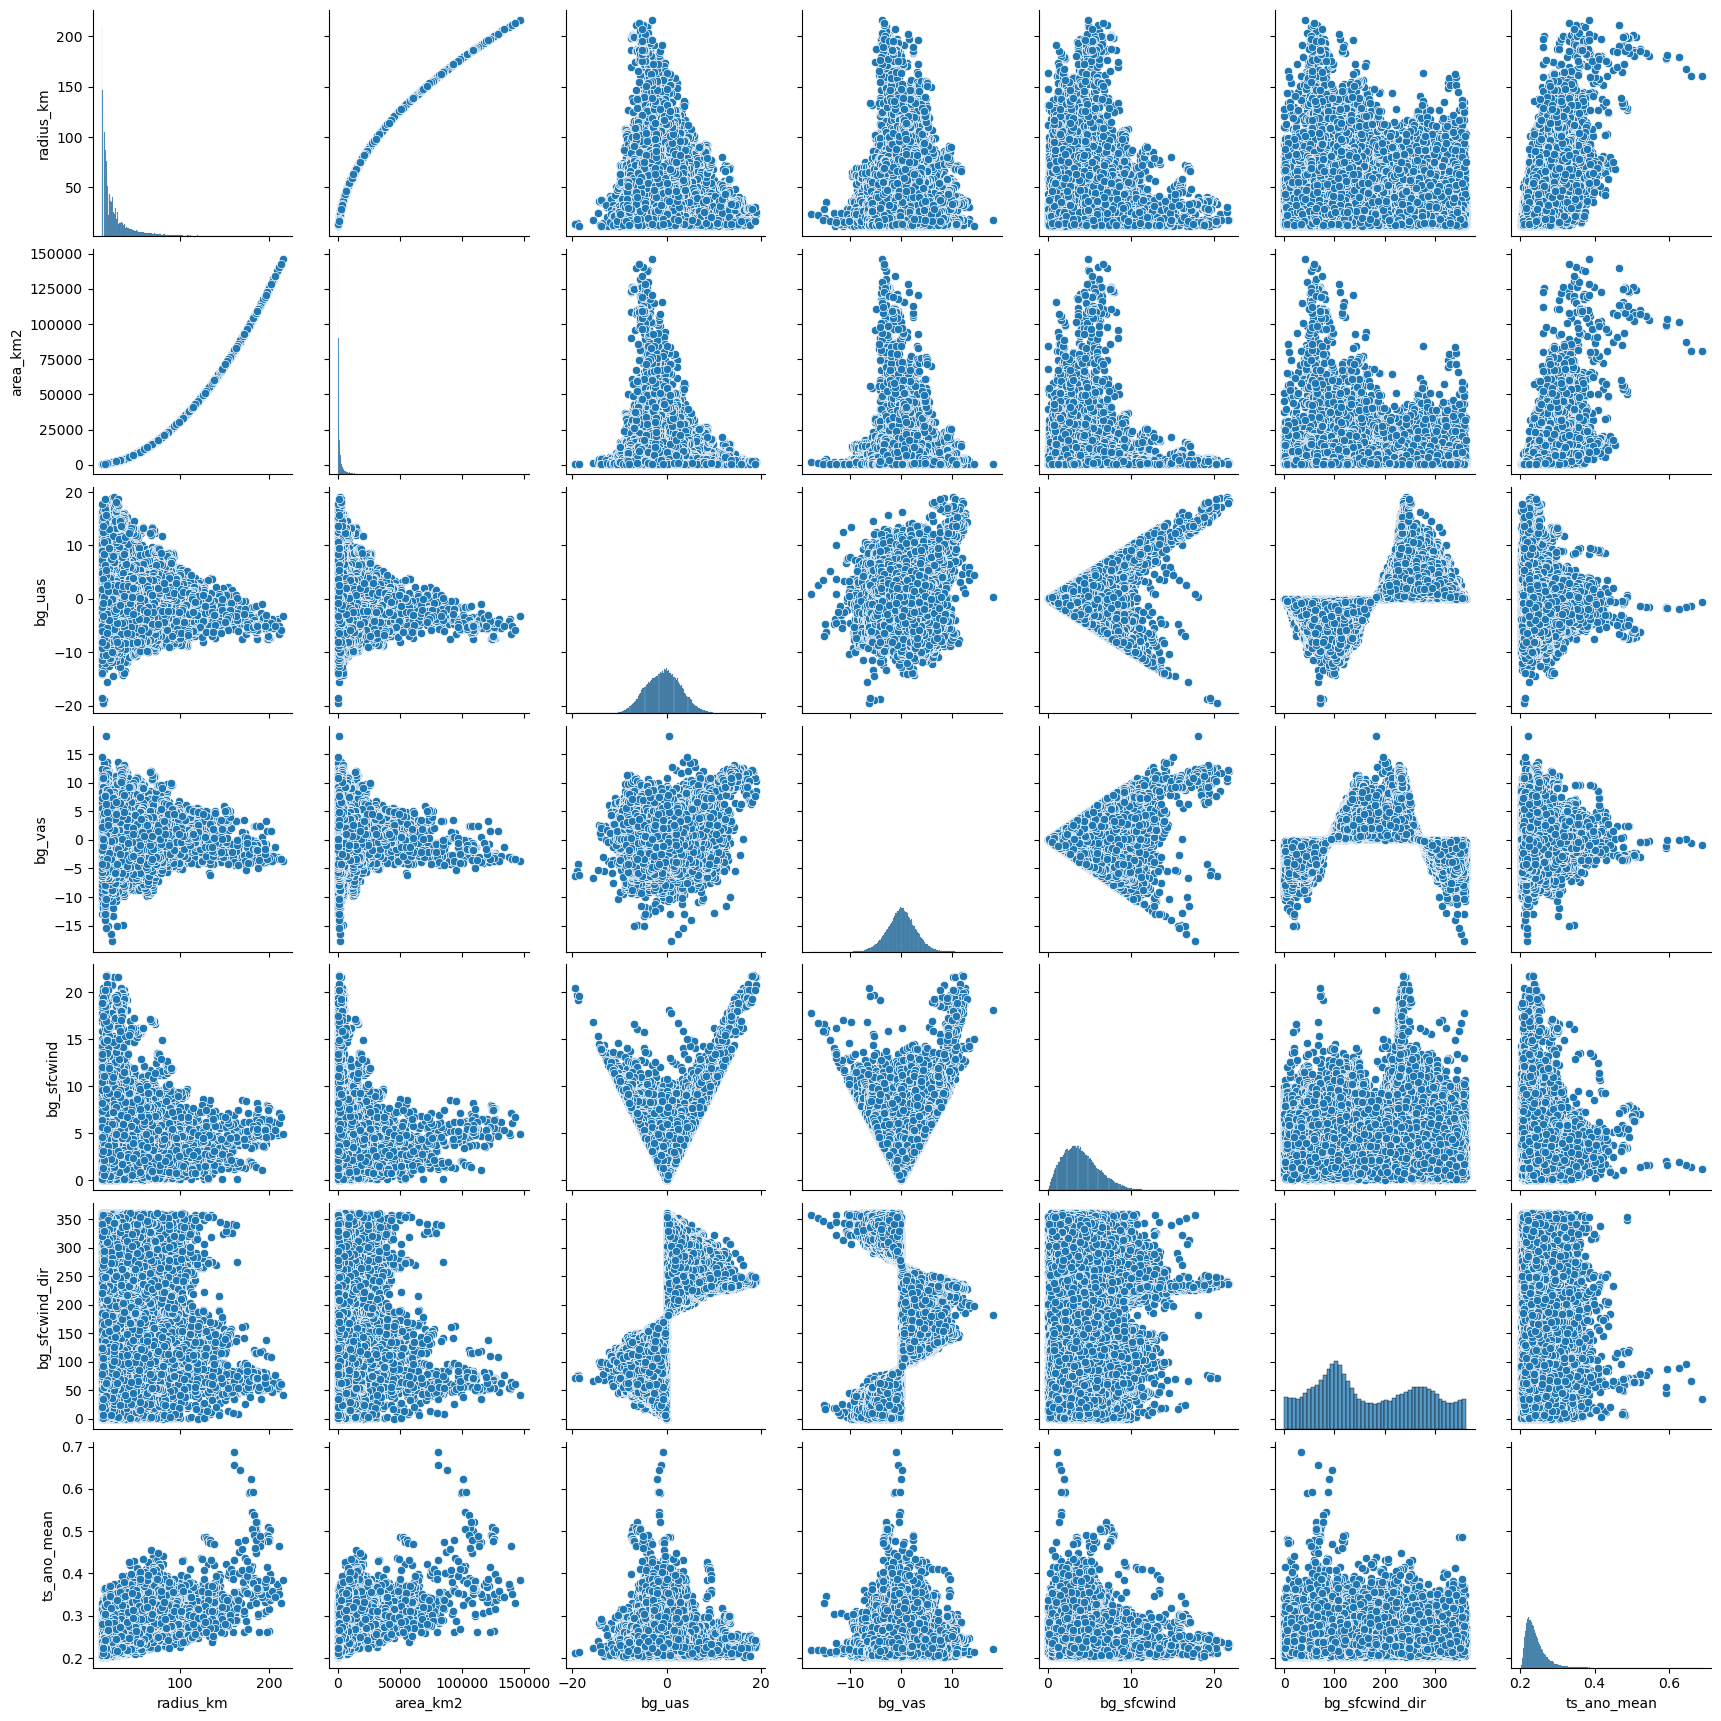

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to dataframe
df = feature_props_rainbelt.to_dataframe().reset_index()

# (Optional) drop coordinate columns if you only want dataset variables
df_vars = df[feature_props_rainbelt.data_vars]

# Create pairplot
sns.pairplot(df_vars)
plt.show()

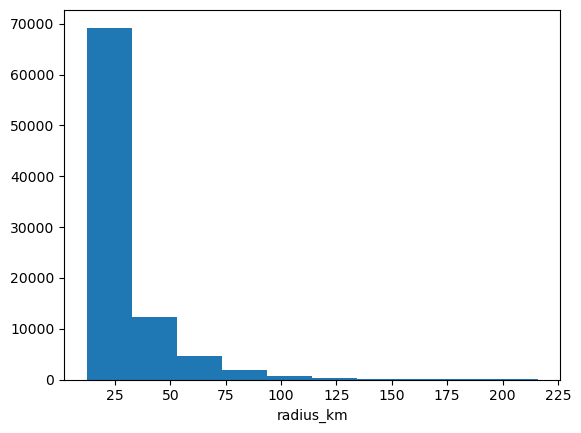

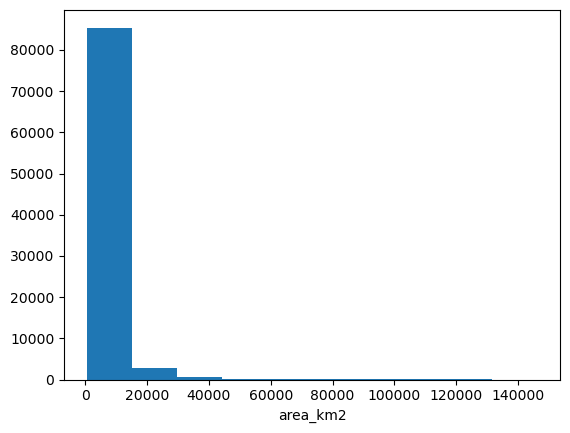

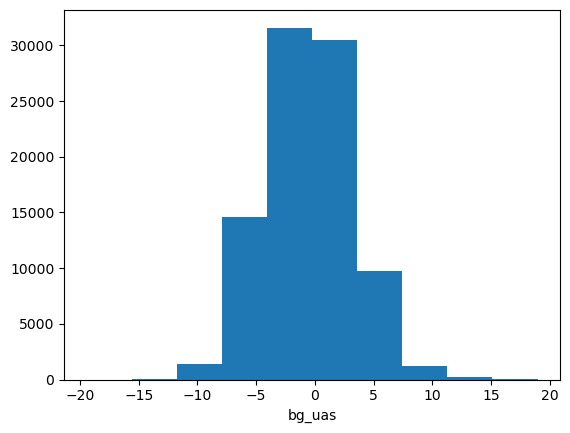

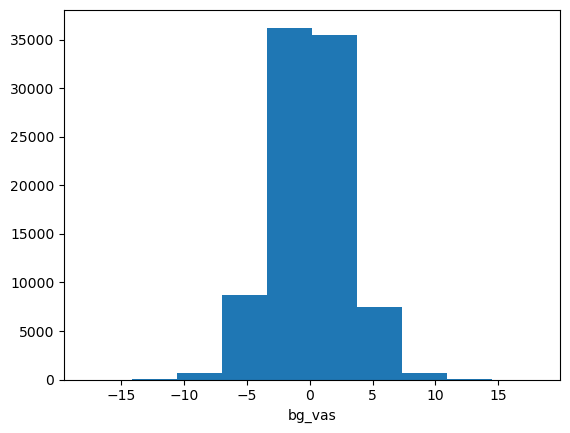

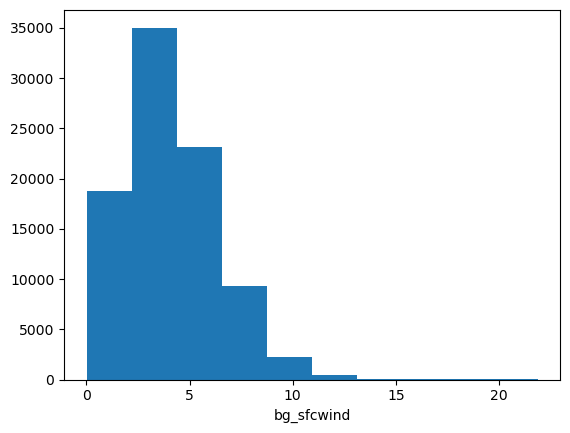

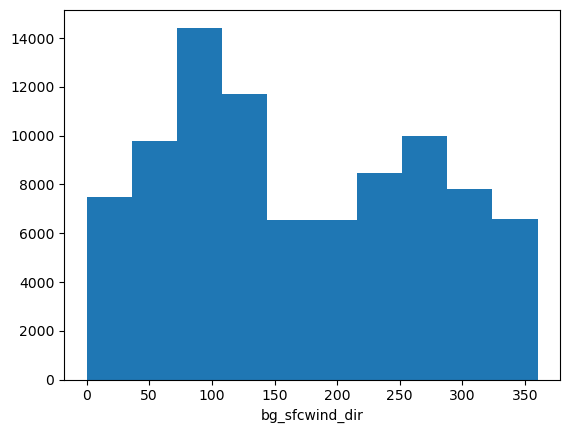

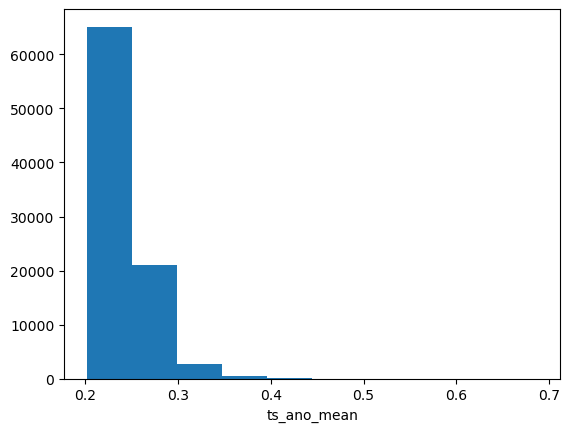

In [ ]:
import matplotlib.pyplot as plt
for var in keep_props:
    plt.hist(feature_props_rainbelt[var])
    plt.xlabel(var)
    plt.show()


### Visualization of composites

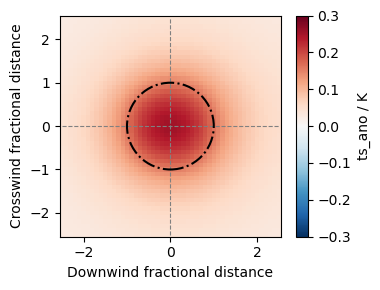

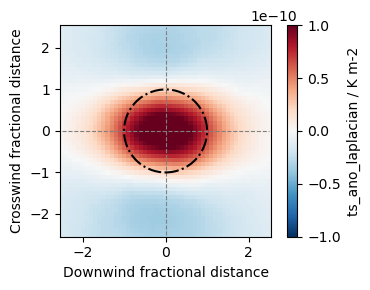

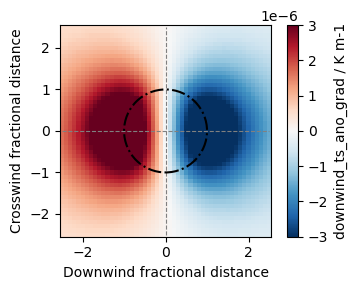

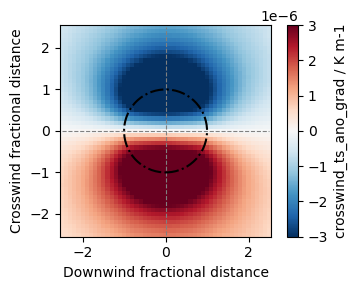

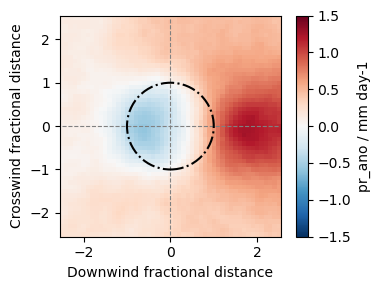

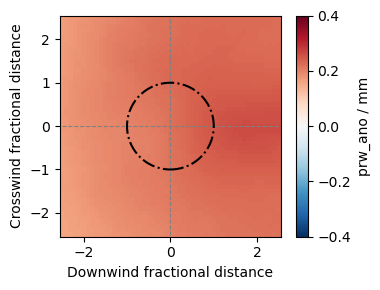

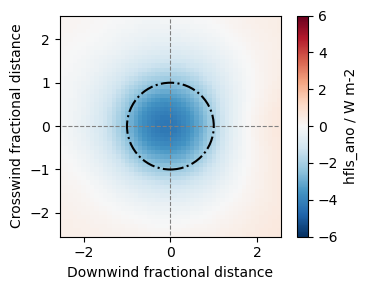

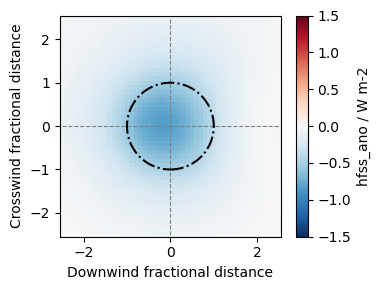

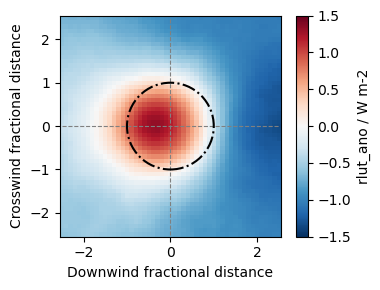

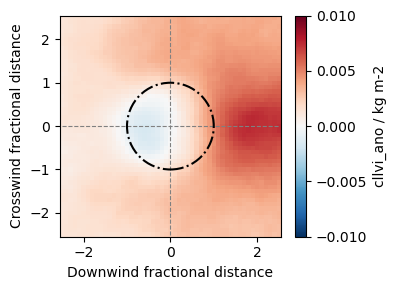

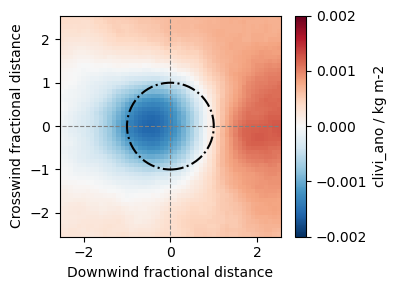

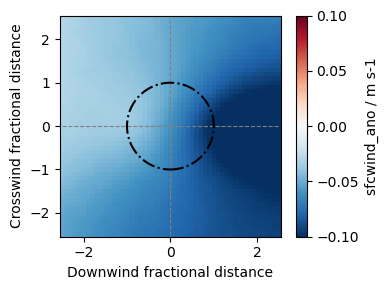

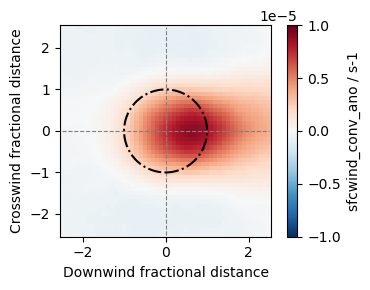

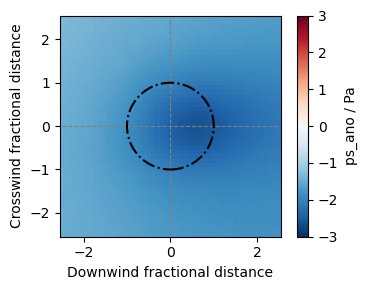

In [ ]:
import pycompo.core.plot as pcplot
import importlib as implib
implib.reload(pcplot)

for var in full_compo.data_vars:
    if len(full_compo[var].dims) >= 2:
        pcplot.plot_composite(full_compo[var])

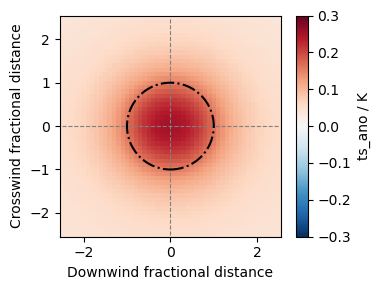

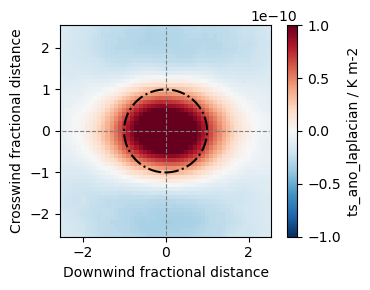

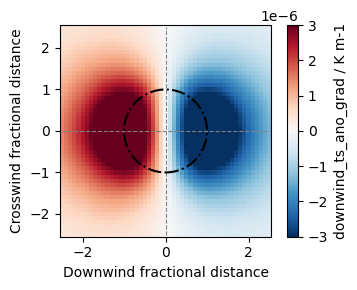

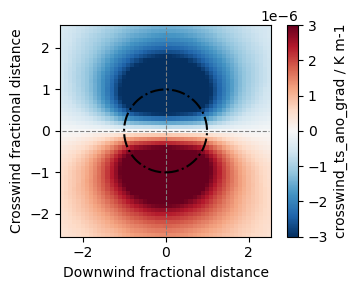

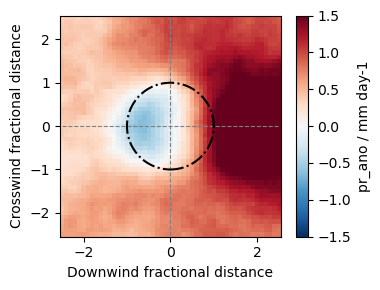

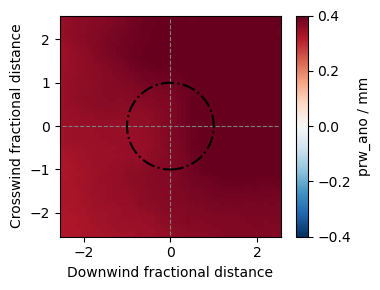

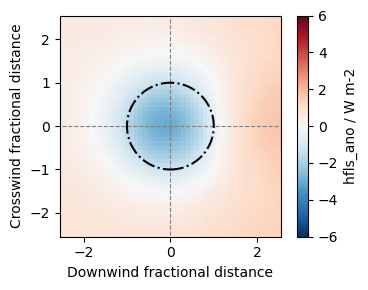

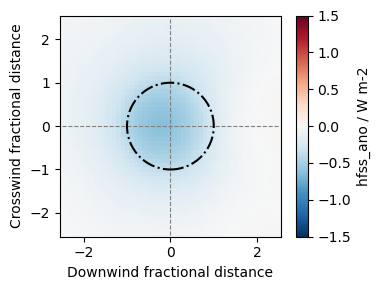

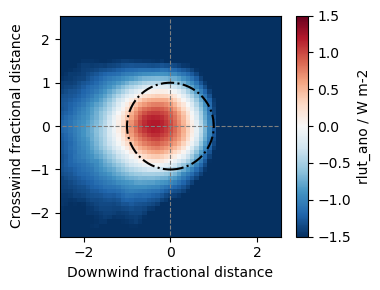

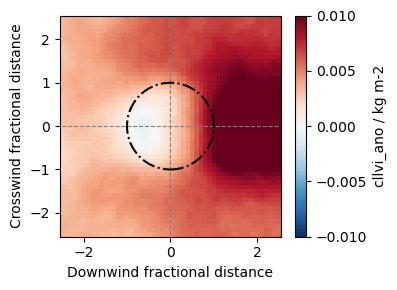

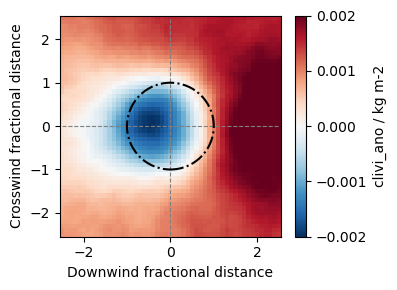

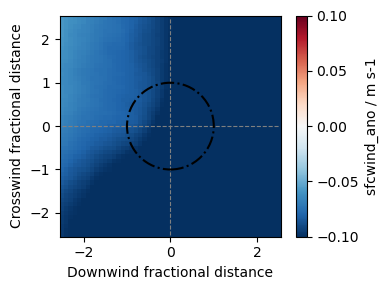

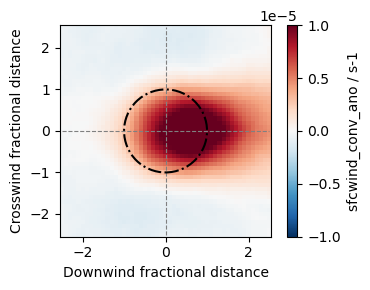

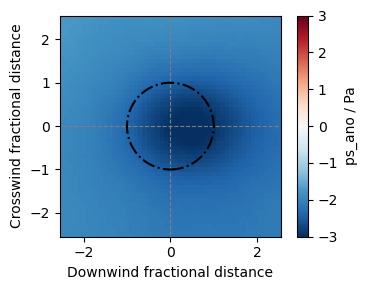

In [ ]:
import pycompo.core.plot as pcplot
import importlib as implib
implib.reload(pcplot)

for var in rainbelt_compo.data_vars:
    if len(rainbelt_compo[var].dims) >= 2:
        pcplot.plot_composite(rainbelt_compo[var])

### Plot rainbelt subsampling mask

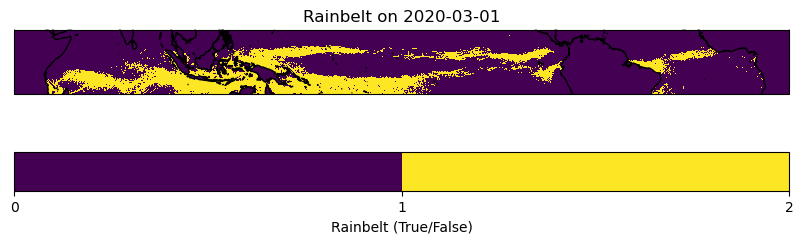

In [ ]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-155))
rainbelt.sel(time=feature['time']).plot(
    ax=ax, transform=ccrs.PlateCarree(),
    levels=[0, 1, 2],
    cbar_kwargs={'label': 'Rainbelt (True/False)', 'orientation': 'horizontal'}
)
ax.coastlines()
ax.set_title(f"Rainbelt on {str(feature['time'].values)[:10]}")
plt.show()

fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-155))
pr_clim.sel(time=feature['time']).plot(
    ax=ax, transform=ccrs.PlateCarree(), 
    cbar_kwargs={'label': 'Pr (mm/day)', 'orientation': 'horizontal'},
    levels=np.arange(0,21,2)
)
ax.coastlines()
ax.set_title(f"Rainbelt on {str(feature['time'].values)[:10]}")
plt.show()